In [1]:
import nrrd
import numpy as np
from utils import imshow

# readdata, header = nrrd.read('../data/1241031155/9.40CHESTSegmentation.seg.nrrd')
labeldata, header = nrrd.read('../data/1241031155/9.40CHESTSegmentation-label.nrrd')
image, header2 = nrrd.read('../data/1241031155/9.40CHESTABDPELVIS.nrrd')

(512, 512, 265)
(512, 512, 265)


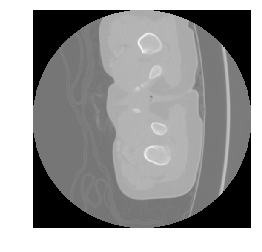

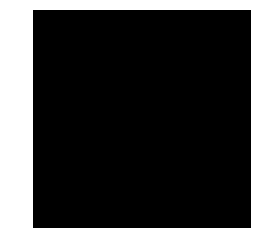

In [2]:
print(image.shape)
print(labeldata.shape)
imshow(image)
imshow(labeldata)

In [3]:

image = np.swapaxes(image, 0, 2)
labeldata = np.swapaxes(labeldata, 0, 2)

#add the fourth dimension (modality) which is just 1
image = np.expand_dims(image, axis=3)
labeldata = np.expand_dims(labeldata, axis=3)

print(image.shape)
print(labeldata.shape)

(265, 512, 512, 1)
(265, 512, 512, 1)


(1, 512, 512, 1)
(1, 512, 512, 1)


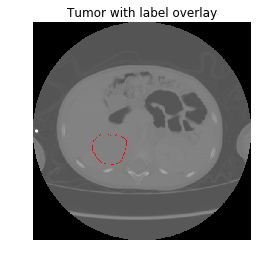

In [4]:
lbl = labeldata[[132],...]
img = image[[132],...]

print(img.shape)
print(lbl.shape)

# imshow(img)
# imshow(lbl)
imshow(dat=img, lbl=lbl, title='Tumor with label overlay')

In [5]:
import tensorflow as tf


print(type(img))
print(img.shape)


X = tf.placeholder(tf.float32, [None, 512, 512, 1])

# errors because it expects X to be 4-d
conv = tf.layers.conv2d(X, filters=8, kernel_size=(3, 3), padding='same')

# The input images in the variable `dat` are matrices of shape `1 x 240 x 240 x 4`.
# should we reshape our data to be 4D as well? ie to become something like 1 x 512 x 512 x 1


relu = tf.nn.relu(conv)
pool = tf.layers.max_pooling2d(relu, pool_size=(2, 2), strides=(4, 4))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

output = sess.run(pool, feed_dict={X: img})

print(output.shape)

<class 'numpy.ndarray'>
(1, 512, 512, 1)
(1, 128, 128, 8)


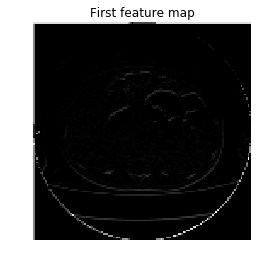

In [6]:
imshow(output[..., 0], title='First feature map')


In [7]:
sess.close()


In [8]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, 512, 512, 1], name='X')
y = tf.placeholder(tf.int32, shape=[None], name='y')
mode = tf.placeholder(tf.bool, name='mode')

In [9]:
import net

In [10]:
pred = net.create_classifier2(X, training=mode)
print(pred.shape)
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=pred)

(?, 2)


In [11]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)
print(lbl.shape)

(1, 512, 512, 1)


(1, 512, 512, 1)
(1, 512, 512, 1)
REAL (tumor, y/n?): y
PRED (tumor, y/n?): n
LOSS (lower value is better prediction): 0.966630


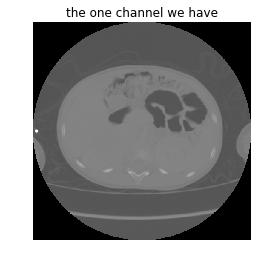

[1]


In [12]:
# dat, lbl = data.load(mode='train', n=1)
print(img.shape)
print(lbl.shape)
lbl = np.max(lbl > 0, axis=(1,2,3)).astype('int32')
sce, logits = sess.run([loss, pred], {X: img, y: lbl, mode: True})

print('REAL (tumor, y/n?): %s' % ('y' if lbl else 'n'))
print('PRED (tumor, y/n?): %s' % ('y' if logits[0, 1] > logits[0, 0] else 'n'))
print('LOSS (lower value is better prediction): %f' % sce)

imshow(img[..., 0], title='the one channel we have')
print(lbl)

In [13]:
sess.close()

In [14]:
# taken from: https://www.tensorflow.org/tutorials/estimators/cnn
print("new section")

new section


In [15]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  input_layer = tf.reshape(features["x"], [-1, 512, 512, 1])

  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2 and Pooling Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Dense Layer
  pool2_flat = tf.reshape(pool2, [-1, 16 * 16 * 64])
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
  logits = tf.layers.dense(inputs=dropout, units=2)

  print("printing logit info:")
  print(type(logits))
  print(logits.shape)

    
    
  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [16]:
# main starts here

# Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
# train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
# eval_data = mnist.test.images # Returns np.array
# eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)


Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [17]:
print(type(train_labels))
print(train_labels.shape)
print(train_labels[0])

<class 'numpy.ndarray'>
(55000,)
7


In [18]:
 
labeldata, header = nrrd.read('../data/1241031155/9.40CHESTSegmentation-label.nrrd')
image, header2 = nrrd.read('../data/1241031155/9.40CHESTABDPELVIS.nrrd')

In [19]:
print(type(image))
# image = image.astype(np.float32)
# print(image)
print(image.shape)
print(type(image[0][0][0]))

<class 'numpy.ndarray'>
(512, 512, 265)
<class 'numpy.int32'>


In [20]:
image = np.swapaxes(image, 0, 2)
labeldata = np.swapaxes(labeldata, 0, 2)

#add the fourth dimension (modality) which is just 1
image = np.expand_dims(image, axis=3)
labeldata = np.expand_dims(labeldata, axis=3)

image = image.astype(np.float32)

print(image.shape)
print(labeldata.shape)

print(np.linalg.matrix_rank(labeldata))

(265, 512, 512, 1)
(265, 512, 512, 1)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [21]:
# image = np.swapaxes(image, 0, 2)
# lbl = np.swapaxes(readdata, 0, 2)
train_data = image
# train_labels = labeldata

print(type(train_data))
print(train_data.shape)

neuro_classifier = tf.estimator.Estimator(
model_fn=cnn_model_fn, model_dir="/tmp/neuro_convnet_model")

<class 'numpy.ndarray'>
(265, 512, 512, 1)
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/neuro_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x113351550>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [22]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [23]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

In [24]:
neuro_classifier.train(
    input_fn=train_input_fn,
    steps=20000,
    hooks=[logging_hook])

ValueError: Length of tensors in x and y is mismatched. All elements in x and y must have the same length.
Shapes in x: {'x': (265, 512, 512, 1)}
Shapes in y: (55000,)


In [ ]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)